In [1]:
# MO444-A 2s/2017 - Second assignment
#
#         Group 05
#
# - Anderson Rossanez (124136)
# - Bruno Branta Lopes (31470)
#

from __future__ import print_function
import glob
from math import sqrt
import matplotlib.pyplot as plt
import numpy as np
from scipy import misc
from skimage.io import imread
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
import tensorflow as tf

# Some definitions
classes = np.asarray(['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])
int_classes = preprocessing.LabelEncoder().fit_transform(classes) # [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
onehot_encoder = preprocessing.OneHotEncoder(sparse=False)
onehot_classes = onehot_encoder.fit_transform(int_classes.reshape(len(int_classes), 1))

def load_image_dataset(name, n=None):
    X = []
    Y = []
    with open('cifar-10/%s/labels' % name) as labels:
        i = 0
        for path in sorted(glob.glob('cifar-10/%s/*.png' % name)):
            # Reading the images as grayscale to have a 32x32 matrix,
            # instead of a 32x32x3 matrix in case of RGB.
            X.append(imread(path, as_grey=True))
            Y.append(int(labels.next()))
            i += 1
            if n != None and i >= n:
                break
    return np.array(X), np.array(Y)

/System/Library/Frameworks/Python.framework/Versions/2.7/Extras/lib/python/scipy/sparse/coo.py:200: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  if np.rank(self.data) != 1 or np.rank(self.row) != 1 or np.rank(self.col) != 1:
/System/Library/Frameworks/Python.framework/Versions/2.7/Extras/lib/python/scipy/sparse/compressed.py:130: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  if np.rank(self.data) != 1 or np.rank(self.indices) != 1 or np.rank(self.indptr) != 1:


In [2]:
# Load train dataset
data_X, data_Y = load_image_dataset('train')

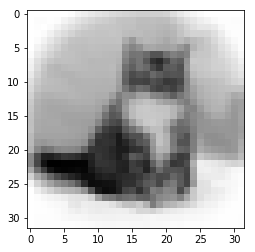

Label: cat


In [3]:
# Take a look at a sample and its class (207 should be a cat [3])
plt.imshow(data_X[207], cmap='gray')
plt.show()

print('Label: %s' % classes[int(data_Y[207])])

In [4]:
# Flatten data to 1-D
def flatten_data(data):
    print('Previous shape: {}'.format(data.shape))
    reshaped = data.reshape(-1, 32*32)
    print('Flattened shape: {}'.format(reshaped.shape))
    return reshaped

data_X = flatten_data(data_X)

Previous shape: (50000, 32, 32)
Flattened shape: (50000, 1024)


In [5]:
# Implementing K-Fold to help avoiding overfitting
from sklearn.model_selection import KFold
from datetime import datetime

random_state = np.random.RandomState(1)

# prepare for 5-fold execution
k5_fold = KFold(n_splits=5, shuffle=True, random_state=random_state)

def run_kfold(method, data_Y, data_X, scale=False):
    train_precision, train_recall, train_f1 = [], [], []
    validation_precision, validation_recall, validation_f1 = [], [], []
    start_time = datetime.now()
    k = 0
    print('k', end=' ')
    model = None

    for train_index, validation_index in k5_fold.split(data_X):
        k += 1
        print(k, end=' ')
        
        train_data_X, train_data_Y = data_X[train_index], data_Y[train_index]
        validation_data_X, validation_data_Y = data_X[validation_index], data_Y[validation_index]
        
        if scale:
            model_scaler = preprocessing.StandardScaler()
            train_data_X = model_scaler.fit_transform(train_data_X)
            validation_data_X = model_scaler.transform(validation_data_X)

        # Train the model(s) using the training data
        model = method(train_data_X, train_data_Y)
        
        # Predict training data
        predicted_train_data_Y = model.predict(train_data_X)
        train_precision.append(precision_score(train_data_Y, predicted_train_data_Y, average='weighted'))
        train_recall.append(recall_score(train_data_Y, predicted_train_data_Y, average='weighted'))
        train_f1.append(f1_score(train_data_Y, predicted_train_data_Y, average='weighted'))
        
        # Predict validation data
        predicted_validation_data_Y = model.predict(validation_data_X)
        validation_precision.append(precision_score(validation_data_Y, predicted_validation_data_Y, average='weighted'))
        validation_recall.append(recall_score(validation_data_Y, predicted_validation_data_Y, average='weighted'))
        validation_f1.append(f1_score(validation_data_Y, predicted_validation_data_Y, average='weighted'))
    
    print('time elapsed: {}\n'.format(datetime.now() - start_time))
    print('             Precision  Recall  F1 Score')
    print('Training:      %5.2f    %5.2f   %5.2f' % (np.mean(train_precision), np.mean(train_recall), np.mean(train_f1)))
    print('Validation:    %5.2f    %5.2f   %5.2f' % (np.mean(validation_precision), np.mean(validation_recall), np.mean(validation_f1)))
    return model

In [6]:
# Create a baseline One-vs-All logistic regression model
ova_lr_model = LogisticRegression(multi_class='ovr', solver='lbfgs', max_iter=100)
run_kfold(lambda X, Y: ova_lr_model.fit(X, Y), data_Y, data_X, scale=True)

k 1 2 3 4 5 time elapsed: 0:03:23.343597

             Precision  Recall  F1 Score
Training:       0.34     0.35    0.34
Validation:     0.27     0.27    0.27


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
          verbose=0, warm_start=False)

In [7]:
# Create a Multinomial (Softmax) logistic regression model
mn_lr_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=100)
run_kfold(lambda X, Y: mn_lr_model.fit(X, Y), data_Y, data_X, scale=True)

k 1 2 3 4 5 time elapsed: 0:01:01.747849

             Precision  Recall  F1 Score
Training:       0.34     0.34    0.34
Validation:     0.27     0.28    0.27


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [8]:
# Neural Networks
class NeuralNetwork(object):
    
    def __init__(self, input_size, output_size, learning_rate=0.5, epochs=10, batch_size=100):
        self.learning_rate=learning_rate
        self.epochs=epochs
        self.batch_size=batch_size
        
        # input data placeholders
        self.x = tf.placeholder(tf.float32, [None, input_size])
        # output data placeholder
        self.y = tf.placeholder(tf.float32, [None, output_size])

        # now declare the weights connecting the input to the hidden layer
        W1 = tf.Variable(tf.random_normal([input_size, 300], stddev=0.03), name='W1')
        b1 = tf.Variable(tf.random_normal([300]), name='b1')

        # and the weights connecting the hidden layer to the output layer
        W2 = tf.Variable(tf.random_normal([300, output_size], stddev=0.03), name='W2')
        b2 = tf.Variable(tf.random_normal([output_size]), name='b2')
        
        # hidden layer's output
        Z1 = tf.add(tf.matmul(self.x, W1), b1)
        a1 = tf.nn.relu(Z1)
        
        # output with softmax activation
        Z2 = tf.add(tf.matmul(a1, W2), b2)
        self.y_ = tf.nn.softmax(Z2)
        
        y_clipped = tf.clip_by_value(self.y_, 1e-10, 0.9999999)
        self.cross_entropy = -tf.reduce_mean(tf.reduce_sum(self.y * tf.log(y_clipped) + (1 - self.y) * tf.log(1 - y_clipped), axis=1))
        # add an optimizer
        self.optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(self.cross_entropy)
        
        # finally setup the initialisation operator
        self.init_op = tf.global_variables_initializer()
        
        # define an accuracy assessment operation
        correct_prediction = tf.equal(tf.argmax(self.y, 1), tf.argmax(self.y_, 1))
        self.accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

        self.session = tf.Session()
        self.session.run(self.init_op)

    def fit(self, X, Y):
        # Apply One Hot Encoding
        Y = onehot_encoder.transform(Y.reshape(len(Y), 1))
        
        # start the session
        for epoch in range(self.epochs):
            _, c = self.session.run([self.optimizer, self.cross_entropy], feed_dict={self.x: X, self.y: Y})
            print("Epoch:", (epoch + 1))
        print(self.session.run(self.accuracy, feed_dict={self.x: X, self.y: Y}))

        return self

    def predict(self, X):
        # Forward propagation
        return self.session.run(self.y_, feed_dict={self.x: X})

In [9]:
# Neural Network with a single hidden layer
nn_single_hl_model = NeuralNetwork(input_size=len(data_X[0]), output_size=len(classes))
#run_kfold(lambda X, Y: nn_single_hl_model.fit(X, Y), data_Y, data_X, scale=True)
nn_single_hl_model.fit(data_X, data_Y)
print(nn_single_hl_model.predict(data_X[0:2]))

Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
0.1
[[  5.58083099e-37   0.00000000e+00   5.39958293e-29   0.00000000e+00
    1.25233580e-29   1.09575393e-29   1.00000000e+00   1.46335195e-30
    0.00000000e+00   3.59819875e-23]
 [  0.00000000e+00   0.00000000e+00   2.02655887e-33   0.00000000e+00
    4.28415574e-34   3.16188006e-34   1.00000000e+00   3.68308381e-35
    0.00000000e+00   1.19920848e-26]]
